#Tarea 4
#Ricardo Zamora Mennigke
#Métodos Calibración de Modelos

Pregunta 1: [40 puntos] En esta pregunta utiliza los datos (tumores.csv). Se trata de un conjunto de datos de caracter´ısticas del tumor cerebral que incluye cinco variables de primer orden y ocho de textura y cuatro par´ametros de evaluaci´on de la calidad con el nivel objetivo. La variables son: Media, Varianza, Desviaci´on est´andar, Asimetr´ıa, Kurtosis, Contraste, Energ´ıa, ASM (segundo momento angular), Entrop´ıa, Homogeneidad, Disimilitud, Correlaci´on, Grosor, PSNR (Pico de la relaci´on se˜nal-ruido), SSIM (´Indice de Similitud Estructurada), MSE (Mean Square Error), DC (Coeficiente de Dados) y la variable a predecir tipo (1 = Tumor, 0 = No-Tumor).
Realice lo siguiente:

1. Cargue la tabla de datos tumores.csv en Python

In [1]:
import numpy as np
import pandas as pd
import random as rd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from matplotlib import colors as mcolors
import seaborn as sns

C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pasada = os.getcwd()
os.chdir("C:/Users/rzamoram/OneDrive - Intel Corporation/Documents/Machine Learning/Métodos Supervisados con Python/Clase 01")
print(os.getcwd())
datos = pd.read_csv('tumores.csv',delimiter=',',decimal=".")
datos['imagen'] = datos['imagen'].astype('category')
print(datos.shape)
print(datos.head())
print(datos.info())

C:\Users\rzamoram\OneDrive - Intel Corporation\Documents\Machine Learning\Métodos Supervisados con Python\Clase 01
(1275, 18)
   imagen      media     varianza  desviacion.estandar  entropia  asimetria  \
0  Image1  23.448517  2538.985627            50.388348  0.651174   1.984202   
1  Image2   4.398331   834.853030            28.893823  0.953532   6.495203   
2  Image3   3.244263   642.059166            25.338886  0.966065   7.772860   
3  Image4   8.511353  1126.214187            33.559115  0.868765   3.763142   
4  Image5  21.000793  2235.316978            47.279139  0.684724   1.936029   

    kurtosis   contraste   energia       asm  homogeneidad  disiminitud  \
0   5.421042  181.467713  0.781557  0.610831      0.847033     2.765411   
1  43.349355   76.745886  0.972770  0.946281      0.980762     0.548605   
2  61.756034   81.752406  0.980161  0.960715      0.985066     0.540411   
3  15.107579  362.291213  0.921786  0.849690      0.949295     2.765725   
4   4.722343  312.439226

In [3]:
def distribucion_variable_predecir(data:DataFrame,variable_predict:str):
    colors = list(dict(**mcolors.CSS4_COLORS))
    df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
    fig = plt.figure(figsize=(10,9))
    g = fig.add_subplot(111)
    countv = 0
    titulo = "Distribución de la variable %s" % variable_predict
    for i in range(df.shape[0]):
        g.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
        countv = countv + df.iloc[i]
    vals = g.get_xticks()
    g.set_xlim(0,1)
    g.set_yticklabels("")
    g.set_title(titulo)
    g.set_ylabel(variable_predict)
    g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
    countv = 0 
    for v in df.iloc[:,0]:
        g.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
        countv = countv + v
    g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)

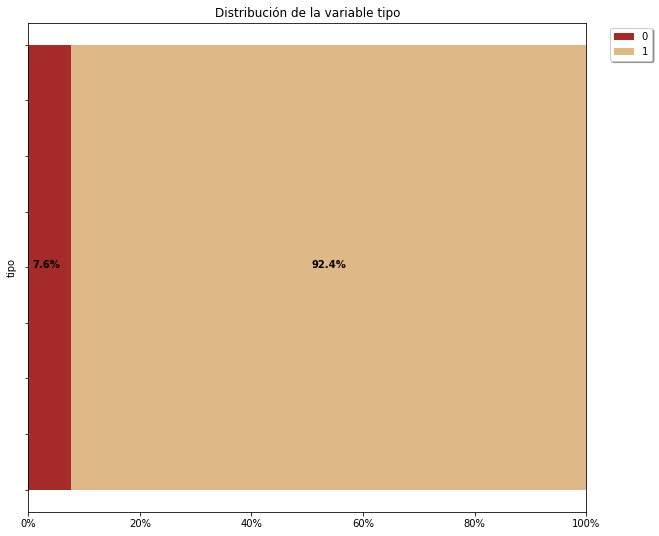

In [4]:
distribucion_variable_predecir(datos,"tipo")

Problema desequilibrado

In [5]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    precision_positiva = MC[1][1]/(MC[1][1] + MC[1][0])
    precision_negativa = MC[0][0]/(MC[0][0] + MC[0][1])
    falsos_positivos = 1 - precision_negativa
    falsos_negativos = 1 - precision_positiva
    asertividad_positiva = MC[1][1]/(MC[0][1] + MC[1][1])
    asertividad_negativa = MC[0][0]/(MC[0][0] + MC[1][0])
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":precision_global, 
            "Error Global":error_global, 
            "Precisión por categoría":precision_categoria,
            "Precision Positiva (PP)": precision_positiva, 
            "Precision Negativa (PN)":precision_negativa, 
            "Falsos Positivos(FP)": falsos_positivos,
            "Falsos Negativos (FN)": falsos_negativos,
            "Asertividad Positiva (AP)": asertividad_positiva,
            "Asertividad Negativa (NP)": asertividad_negativa}

2. Comparare todos los m´etodos predictivos vistos en el curso con esta tabla de datos utilizado la curva ROC y el ´area bajo la curva ROC. Aqu´ı interesa predecir en la variable tipo. Compare los m´etodos SVM, KNN, ´Arboles, Bosques, ADA Boosting, eXtreme Gradient Boosting, Bayes, LDA, QDA y Redes Neuronales del paquete Keras y del MLPClassifier. ¿Se puede determinar con claridad cu´al m´etodos es el mejor?

In [6]:
from sklearn.ensemble import RandomForestClassifier


def plotROC(real, prediccion, color = "red", label = None):
    fp_r, tp_r, umbral = roc_curve(real, prediccion)
    plt.plot(fp_r, tp_r, lw = 1, color = color, label = label)
    plt.plot([0, 1], [0, 1], lw = 1, color = "black")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title("Curva ROC")

In [7]:
X = datos.iloc[:,1:17] 
print(X.head())
y = datos.iloc[:,17:18] 
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

       media     varianza  desviacion.estandar  entropia  asimetria  \
0  23.448517  2538.985627            50.388348  0.651174   1.984202   
1   4.398331   834.853030            28.893823  0.953532   6.495203   
2   3.244263   642.059166            25.338886  0.966065   7.772860   
3   8.511353  1126.214187            33.559115  0.868765   3.763142   
4  21.000793  2235.316978            47.279139  0.684724   1.936029   

    kurtosis   contraste   energia       asm  homogeneidad  disiminitud  \
0   5.421042  181.467713  0.781557  0.610831      0.847033     2.765411   
1  43.349355   76.745886  0.972770  0.946281      0.980762     0.548605   
2  61.756034   81.752406  0.980161  0.960715      0.985066     0.540411   
3  15.107579  362.291213  0.921786  0.849690      0.949295     2.765725   
4   4.722343  312.439226  0.804184  0.646711      0.880301     3.006660   

   correlacion        psnr      ssim       mse        dc  
0     0.968576   97.974630  0.777011  0.171163  0.303989  
1   

In [8]:
instancia_svm = SVC(kernel = "rbf",gamma='scale',probability=True)
instancia_svm.fit(X_train, y_train.iloc[:,0].values)
#print("Probabilidad del No y del Si:\n",instancia_svm.predict_proba(X_test))
probabilidad = instancia_svm.predict_proba(X_test)[:, 1]
#print("Probabilidad de Si (o sea del 1):\n",probabilidad)

In [9]:
instancia_bosques = RandomForestClassifier(n_estimators = 300, max_features = 3)
instancia_bosques.fit(X_train, y_train.iloc[:,0].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
instancia_knn = KNeighborsClassifier(n_neighbors=5)
instancia_knn.fit(X_train, y_train.iloc[:,0].values)
#plt.figure(figsize=(10,10))
#plotROC(y_test, instancia_knn.predict_proba(X_test)[:, 1], color = "blue")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [11]:
instancia_tree = DecisionTreeClassifier()
instancia_tree.fit(X_train, y_train.iloc[:,0].values)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
instancia_ADA = AdaBoostClassifier(n_estimators=5)
instancia_ADA.fit(X_train, y_train.iloc[:,0].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=5, random_state=None)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
instancia_XGB = GradientBoostingClassifier(n_estimators=5)
instancia_XGB.fit(X_train, y_train.iloc[:,0].values)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
from sklearn.neural_network import MLPClassifier
instancia_classifier = MLPClassifier(solver='lbfgs')
instancia_classifier.fit(X_train, y_train.iloc[:,0].values)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [15]:
from sklearn.naive_bayes import GaussianNB
instancia_bayes = GaussianNB()
instancia_bayes.fit(X_train, y_train.iloc[:,0].values)


GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
instancia_lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
instancia_lda.fit(X_train, y_train.iloc[:,0].values)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='lsqr', store_covariance=False, tol=0.0001)

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
instancia_qda = QuadraticDiscriminantAnalysis()
instancia_qda.fit(X_train, y_train.iloc[:,0].values)

C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

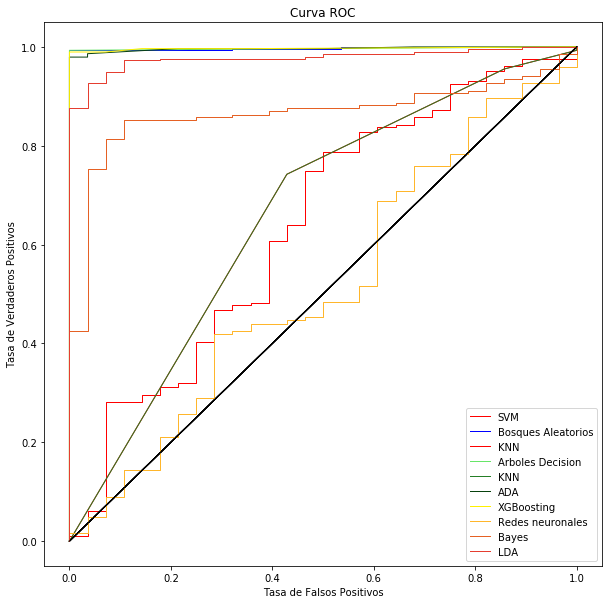

In [18]:
plt.figure(figsize=(10,10))
plotROC(y_test, instancia_svm.predict_proba(X_test)[:, 1], label = "SVM")
plotROC(y_test, instancia_bosques.predict_proba(X_test)[:, 1], color = "blue", label= "Bosques Aleatorios")
plotROC(y_test, instancia_knn.predict_proba(X_test)[:, 1], color = "red", label= "KNN")
plotROC(y_test, instancia_tree.predict_proba(X_test)[:, 1], color = "#67E568", label= "Arboles Decision")
plotROC(y_test, instancia_knn.predict_proba(X_test)[:, 1], color = "#257F27", label= "KNN")
plotROC(y_test, instancia_ADA.predict_proba(X_test)[:, 1], color = "#08420D", label= "ADA")
plotROC(y_test, instancia_XGB.predict_proba(X_test)[:, 1], color = "#FFF000", label= "XGBoosting")
plotROC(y_test, instancia_classifier.predict_proba(X_test)[:, 1], color = "#FFB62B", label= "Redes neuronales")
plotROC(y_test, instancia_bayes.predict_proba(X_test)[:, 1], color = "#E56124", label= "Bayes")
plotROC(y_test, instancia_lda.predict_proba(X_test)[:, 1], color = "#E53E30", label= "LDA")
#plotROC(y_test, instancia_qda.predict_proba(X_test)[:, 1], color = "#7F2353", label= "QDA")
plt.legend(loc = "lower right")

In [19]:
bosques_area = roc_auc_score(y_test, instancia_bosques.predict_proba(X_test)[:, 1])
svm_area = roc_auc_score(y_test, instancia_svm.predict_proba(X_test)[:, 1])
knn_area = roc_auc_score(y_test, instancia_knn.predict_proba(X_test)[:, 1])
tree_area = roc_auc_score(y_test, instancia_tree.predict_proba(X_test)[:, 1])
knn_area = roc_auc_score(y_test, instancia_knn.predict_proba(X_test)[:, 1])
ADA_area = roc_auc_score(y_test, instancia_ADA.predict_proba(X_test)[:, 1])
XGB_area = roc_auc_score(y_test, instancia_XGB.predict_proba(X_test)[:, 1])
red_area = roc_auc_score(y_test, instancia_classifier.predict_proba(X_test)[:, 1])
bayes_area = roc_auc_score(y_test, instancia_bayes.predict_proba(X_test)[:, 1])
lda_area = roc_auc_score(y_test, instancia_lda.predict_proba(X_test)[:, 1])
#qda_area = roc_auc_score(y_test, instancia_qda.predict_proba(X_test)[:, 1])

In [20]:
print("Área bajo la curva ROC en Bosques Aleatorios: {:.3f}".format(bosques_area))
print("Área bajo la curva ROC en KNN: {:.3f}".format(knn_area))
print("Área bajo la curva ROC en Arboles Decision: {:.3f}".format(tree_area))
print("Área bajo la curva ROC en KNN: {:.3f}".format(knn_area))
print("Área bajo la curva ROC en ADA: {:.3f}".format(ADA_area))
print("Área bajo la curva ROC en XGB: {:.3f}".format(XGB_area))
print("Área bajo la curva ROC en red: {:.3f}".format(red_area))
print("Área bajo la curva ROC en bayes: {:.3f}".format(bayes_area))
print("Área bajo la curva ROC en LDA: {:.3f}".format(lda_area))
#print("Área bajo la curva ROC en QDA: {:.3f}".format(qda_area))

Área bajo la curva ROC en Bosques Aleatorios: 0.997
Área bajo la curva ROC en KNN: 0.662
Área bajo la curva ROC en Arboles Decision: 0.997
Área bajo la curva ROC en KNN: 0.662
Área bajo la curva ROC en ADA: 0.996
Área bajo la curva ROC en XGB: 0.997
Área bajo la curva ROC en red: 0.517
Área bajo la curva ROC en bayes: 0.866
Área bajo la curva ROC en LDA: 0.978


De forma visual se denota que hay tres modelos que tienen una curva ROC que tiene muy buen nivel de estimacion. Los cuatro visibles son: XGBoosting, ada-discrete, arboles de decision y bosques aleatorios. Con el area bajo la curva se denota que el mejor desempeno tiene para este calculo es XGBoosting jnuto a arboles de decision y bosques aleatorios, no resulta visible determinar cual es mejor con extrema certeza.

3. ¿Qu´e se puede concluir?

Por un margen tan pequeno ya que los tres superan un 0,99 de poder predictivo en XGBoosting, arboles de decision y bosques aleatorios. Para esto tomando el criterio de grafico de curva ROC, junto al area bajo la curva no se denota visualmente preferencia entre los tres modelos que tienen una curva ROC que tiene muy buen nivel de estimacion. Con el area bajo la curva se denota que el mejor desempeno tiene para este calculo es de los tres por lo que se puede usar para estos casos cualquiera de los tres.

Ejercicio 2: [40 puntos] Esta pregunta utiliza los datos sobre muerte del coraz´on en Sud´africa (SAheart.csv). La variable que queremos predecir es chd que es un indicador de muerte coronaria basado en algunas variables predictivas (factores de riesgo) como son el fumado, la obesidad, las bebidas alcoh´olicas, entre otras. Las variables son:
Realice lo siguiente:

1. Usando Bosques Aleatorios para la tabla SAheart.csv con el 80 % de los datos para la tabla aprendizaje y un 20 % para la tabla testing determine la mejor Probabilidad de Corte, de forma tal que se prediga de la mejor manera posible la categor´ıa Si de la variable chd, pero sin desmejorar de manera significativa la precisi´on global.

In [21]:
import os
import pandas as pd
pasada = os.getcwd()
os.chdir("C:/Users/rzamoram/OneDrive - Intel Corporation/Documents/Machine Learning/Métodos NO Supervisados con Python/Clase 1")
os.getcwd()
ejemplo10 = pd.read_csv("SAheart.csv", delimiter = ';', decimal = ".", header = 0, index_col = 0)
print(ejemplo10.head())
datos = pd.DataFrame(ejemplo10)

     tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age chd
sbp                                                                     
160    12.00  5.73      23.11  Present     49    25.30    97.20   52  Si
144     0.01  4.41      28.61   Absent     55    28.87     2.06   63  Si
118     0.08  3.48      32.28  Present     52    29.14     3.81   46  No
170     7.50  6.41      38.03  Present     51    31.99    24.26   58  Si
134    13.60  3.50      27.78  Present     60    25.99    57.34   49  Si


In [22]:
def recodificar(col, nuevo_codigo):
  col_cod = pd.Series(col, copy=True)
  for llave, valor in nuevo_codigo.items():
    col_cod.replace(llave, valor, inplace=True)
  return col_cod

datos["famhist"] = recodificar(datos["famhist"], {'Present':1,'Absent':2})
datos["chd"] = recodificar(datos["chd"], {'No':0,'Si':1})
print(datos.head())
print(datos.dtypes)
# Conviertiendo la variables en Dummy
datos_dummy = pd.get_dummies(datos)
print(datos_dummy.head())
print(datos_dummy.dtypes)

X = datos.iloc[:,:8] 
print(X.head())
y = datos.iloc[:,8:9] 
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 0)

     tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
sbp                                                                      
160    12.00  5.73      23.11        1     49    25.30    97.20   52    1
144     0.01  4.41      28.61        2     55    28.87     2.06   63    1
118     0.08  3.48      32.28        1     52    29.14     3.81   46    0
170     7.50  6.41      38.03        1     51    31.99    24.26   58    1
134    13.60  3.50      27.78        1     60    25.99    57.34   49    1
tobacco      float64
ldl          float64
adiposity    float64
famhist        int64
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object
     tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
sbp                                                                      
160    12.00  5.73      23.11        1     49    25.30    97.20   52    1
144     0.01  4.41      28.61        2     55    28.87   

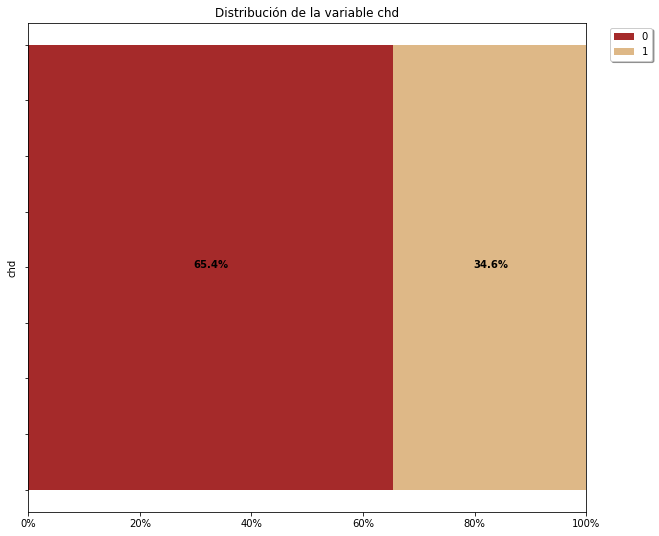

In [26]:
distribucion_variable_predecir(datos,"chd")

Desequilibrado

In [28]:
# bosques aleatorios modelo
instancia_bosques = RandomForestClassifier(n_estimators = 300, max_features = 3)
instancia_bosques.fit(X_train, y_train.iloc[:,0].values)
prediccion = instancia_bosques.predict(X_test)
MC = confusion_matrix(y_test, prediccion)
indices = indices_general(MC,list(np.unique(y)))
for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))


Matriz de Confusión:
[[53  8]
 [17 15]]

Precisión Global:
0.7311827956989247

Error Global:
0.26881720430107525

Precisión por categoría:
          0        1
0  0.868852  0.46875

Precision Positiva (PP):
0.46875

Precision Negativa (PN):
0.8688524590163934

Falsos Positivos(FP):
0.1311475409836066

Falsos Negativos (FN):
0.53125

Asertividad Positiva (AP):
0.6521739130434783

Asertividad Negativa (NP):
0.7571428571428571


In [29]:
print("Probabilidad del No y del Si:\n",instancia_bosques.predict_proba(X_test))
probabilidad = instancia_bosques.predict_proba(X_test)[:, 1]
print("Probabilidad de Si (o sea del 1):\n",probabilidad)


Probabilidad del No y del Si:
 [[0.62333333 0.37666667]
 [0.63666667 0.36333333]
 [0.67666667 0.32333333]
 [0.3        0.7       ]
 [0.72       0.28      ]
 [0.48       0.52      ]
 [0.92       0.08      ]
 [0.59666667 0.40333333]
 [0.95       0.05      ]
 [0.46333333 0.53666667]
 [0.55       0.45      ]
 [0.24666667 0.75333333]
 [0.58333333 0.41666667]
 [0.61666667 0.38333333]
 [0.46666667 0.53333333]
 [0.53333333 0.46666667]
 [0.23666667 0.76333333]
 [0.95333333 0.04666667]
 [0.48666667 0.51333333]
 [0.81666667 0.18333333]
 [0.39666667 0.60333333]
 [0.71333333 0.28666667]
 [1.         0.        ]
 [0.31666667 0.68333333]
 [0.71       0.29      ]
 [0.99666667 0.00333333]
 [0.54       0.46      ]
 [0.81333333 0.18666667]
 [0.64333333 0.35666667]
 [0.31       0.69      ]
 [0.77666667 0.22333333]
 [0.43333333 0.56666667]
 [0.73       0.27      ]
 [0.60333333 0.39666667]
 [0.72       0.28      ]
 [0.8        0.2       ]
 [0.88       0.12      ]
 [0.39       0.61      ]
 [0.31       0.69  

In [31]:
# regla de decision
corte = [0.501, 0.502, 0.503, 0.504, 0.505, 0.506, 0.507, 0.508, 0.509, 0.6, 0.601, 0.602, 0.603, 0.604, 0.605, 0.606, 0.607, 0.608, 0.609]
for c in corte:
    print("===========================")
    print("Probabilidad de Corte: ",c)
    prediccion = np.where(probabilidad > c, 1, 0)
    # Calidad de la predicción 
    MC = confusion_matrix(y_test, prediccion)
    indices = indices_general(MC,list(np.unique(y)))
    for k in indices:
        print("\n%s:\n%s"%(k,str(indices[k])))

Probabilidad de Corte:  0.501

Matriz de Confusión:
[[53  8]
 [17 15]]

Precisión Global:
0.7311827956989247

Error Global:
0.26881720430107525

Precisión por categoría:
          0        1
0  0.868852  0.46875

Precision Positiva (PP):
0.46875

Precision Negativa (PN):
0.8688524590163934

Falsos Positivos(FP):
0.1311475409836066

Falsos Negativos (FN):
0.53125

Asertividad Positiva (AP):
0.6521739130434783

Asertividad Negativa (NP):
0.7571428571428571
Probabilidad de Corte:  0.502

Matriz de Confusión:
[[53  8]
 [17 15]]

Precisión Global:
0.7311827956989247

Error Global:
0.26881720430107525

Precisión por categoría:
          0        1
0  0.868852  0.46875

Precision Positiva (PP):
0.46875

Precision Negativa (PN):
0.8688524590163934

Falsos Positivos(FP):
0.1311475409836066

Falsos Negativos (FN):
0.53125

Asertividad Positiva (AP):
0.6521739130434783

Asertividad Negativa (NP):
0.7571428571428571
Probabilidad de Corte:  0.503

Matriz de Confusión:
[[53  8]
 [17 15]]

Precisión 

Usando una probabilidad de corte incialmente estimada unicamente con 0.5, se denota que la exactitud del modelo esta entorno al 0.7311827956989247. Luego de implementar y probar varias probabilidad de corte se denota que conforme aumenta la probabilidad de corte la precision global aumenta, pero opuesto parece disminuir la precision por categoria de Si en la variable. A partir de probabilidad de corte de 0.5 la precision de prediccion de Si se viene abajo de 0,50, en este caso, se vuelve poco servible. Pero por otro lado la precision global del modelo es inferior a 0,50 cuando la probabilidad de corte es menor de 0.1. Parece que elegir un punto entre estos conviene para maximizar la precision y la precision del Si, desde un punto de vista personal la probabilidad de corte deberia estar segun las indicaciones de este modelo en 0.50, ya que es aqui donde las precisiones llegan a puntos similares la categoria Si llega a 0.46875 y la exactitud del modelo se estima en 0.7311, es decir, en ambas estimaciones parece estar parecido.

2. Repita el ejercicio anterior usando XGBoosting. ¿Cambi´o la probabilidad de corte? Explique

In [32]:
# XGB modelo
instancia_XGB = GradientBoostingClassifier(n_estimators=5)
instancia_XGB.fit(X_train, y_train.iloc[:,0].values)
prediccion = instancia_XGB.predict(X_test)
MC = confusion_matrix(y_test, prediccion)
indices = indices_general(MC,list(np.unique(y)))
for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))

#print("Probabilidad del No y del Si:\n",instancia_XGB.predict_proba(X_test))
probabilidad = instancia_XGB.predict_proba(X_test)[:, 1]
#print("Probabilidad de Si (o sea del 1):\n",probabilidad)


Matriz de Confusión:
[[59  2]
 [28  4]]

Precisión Global:
0.6774193548387096

Error Global:
0.32258064516129037

Precisión por categoría:
          0      1
0  0.967213  0.125

Precision Positiva (PP):
0.125

Precision Negativa (PN):
0.9672131147540983

Falsos Positivos(FP):
0.032786885245901676

Falsos Negativos (FN):
0.875

Asertividad Positiva (AP):
0.6666666666666666

Asertividad Negativa (NP):
0.6781609195402298


In [33]:
# regla de decision
corte = [0.501, 0.502, 0.503, 0.504, 0.505, 0.506, 0.507, 0.508, 0.509, 0.6, 0.601, 0.602, 0.603, 0.604, 0.605, 0.606, 0.607, 0.608, 0.609]
for c in corte:
    print("===========================")
    print("Probabilidad de Corte: ",c)
    prediccion = np.where(probabilidad > c, 1, 0)
    # Calidad de la predicción 
    MC = confusion_matrix(y_test, prediccion)
    indices = indices_general(MC,list(np.unique(y)))
    for k in indices:
        print("\n%s:\n%s"%(k,str(indices[k])))

Probabilidad de Corte:  0.501

Matriz de Confusión:
[[59  2]
 [28  4]]

Precisión Global:
0.6774193548387096

Error Global:
0.32258064516129037

Precisión por categoría:
          0      1
0  0.967213  0.125

Precision Positiva (PP):
0.125

Precision Negativa (PN):
0.9672131147540983

Falsos Positivos(FP):
0.032786885245901676

Falsos Negativos (FN):
0.875

Asertividad Positiva (AP):
0.6666666666666666

Asertividad Negativa (NP):
0.6781609195402298
Probabilidad de Corte:  0.502

Matriz de Confusión:
[[59  2]
 [28  4]]

Precisión Global:
0.6774193548387096

Error Global:
0.32258064516129037

Precisión por categoría:
          0      1
0  0.967213  0.125

Precision Positiva (PP):
0.125

Precision Negativa (PN):
0.9672131147540983

Falsos Positivos(FP):
0.032786885245901676

Falsos Negativos (FN):
0.875

Asertividad Positiva (AP):
0.6666666666666666

Asertividad Negativa (NP):
0.6781609195402298
Probabilidad de Corte:  0.503

Matriz de Confusión:
[[59  2]
 [28  4]]

Precisión Global:
0.67

C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\rzamoram\AppData\Local\Continuum\anaconda3\lib\site-packages\

Existe una situacion similar, es decir, conforme aumenta la probabilidad de corte la precision global aumenta, pero opuesto parece disminuir la precision por categoria de Si en la variable. A partir de probabilidad de corte de 0.5 la precision de prediccion de Si se viene abajo de 0,50, en este caso, se vuelve poco servible. Pero por otro lado la precision global del modelo es inferior a 0,50 cuando la probabilidad de corte es menor. Parece que elegir un punto entre estos conviene para maximizar la precision y la precision del Si, desde un punto de vista personal la probabilidad de corte deberia estar segun las indicaciones de este modelo en 0.5 ya que es aqui donde las precisiones llegan a puntos similares la categoria Si llega a 0.125 y la exactitud del modelo se estima en 0.6774193548387096.

Ejercicio 3: [20 puntos] Dada la siguiente tabla:

1. Usando la definici´on de curva ROC calcule y grafique “a mano” la curva ROC, use un umbral T = 0,1 y un paso de 0,1. Es decir, debe hacerlo variando el umbral y calculando las matrices de confusi´on.

###Calculo a mano adjunto en el excel

2. Verifique el resultado anterior usando el c´odigo visto en clase.

Punto i =  1 

Umbral = T =  1.0 

MC =
[[4 0]
 [6 0]] 

Tasa FP =  0.0 

Tasa TP =  0.0
Punto i =  2 

Umbral = T =  0.8 

MC =
[[4 0]
 [5 1]] 

Tasa FP =  0.0 

Tasa TP =  0.17
Punto i =  3 

Umbral = T =  0.7 

MC =
[[3 1]
 [5 1]] 

Tasa FP =  0.25 

Tasa TP =  0.17
Punto i =  4 

Umbral = T =  0.65 

MC =
[[3 1]
 [4 2]] 

Tasa FP =  0.25 

Tasa TP =  0.33
Punto i =  5 

Umbral = T =  0.6 

MC =
[[2 2]
 [4 2]] 

Tasa FP =  0.5 

Tasa TP =  0.33
Punto i =  6 

Umbral = T =  0.5 

MC =
[[1 3]
 [4 2]] 

Tasa FP =  0.75 

Tasa TP =  0.33
Punto i =  7 

Umbral = T =  0.35 

MC =
[[1 3]
 [3 3]] 

Tasa FP =  0.75 

Tasa TP =  0.5
Punto i =  8 

Umbral = T =  0.3 

MC =
[[1 3]
 [2 4]] 

Tasa FP =  0.75 

Tasa TP =  0.67
Punto i =  9 

Umbral = T =  0.25 

MC =
[[0 4]
 [2 4]] 

Tasa FP =  1.0 

Tasa TP =  0.67
Punto i =  10 

Umbral = T =  0.2 

MC =
[[0 4]
 [1 5]] 

Tasa FP =  1.0 

Tasa TP =  0.83
Punto i =  11 

Umbral = T =  0.1 

MC =
[[0 4]
 [0 6]] 

Tasa FP =  1.0 

Tasa TP =  1.0


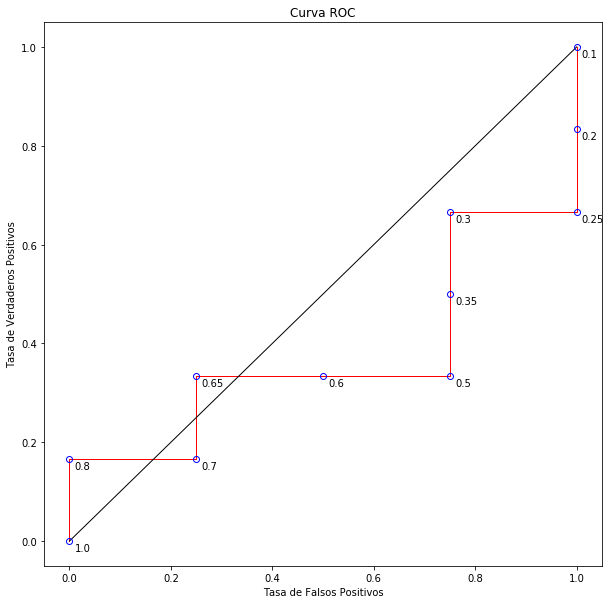

In [34]:
Clase = np.array([1,0,1,0,0,1,1,0,1,1])
Score = np.array([0.8,0.7,0.65,0.6,0.5,0.35,0.3,0.25,0.2,0.1])

# Graficamos ROC con usando roc_curve de sklearn
fp_r, tp_r, umbral = roc_curve(Clase, Score)
plt.figure(figsize=(10,10))
plt.plot(fp_r, tp_r, lw = 1, color = "red")
plt.plot([0, 1], [0, 1], lw = 1, color = "black")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")


# Graficamos puntos con el siguiente algoritmo
i = 1  # Contador
FP_r = -1  # Para que entre al condicional en la primera iteración
TP_r = -1  # Para que entre al condicional en la primera iteración

# linspace genera una sucesión de 201 números del 1 al 0 que equivale a una sucesión del 1 al 0 con paso de 0.005
for Umbral in np.linspace(1, 0, 201):   
    Prediccion = np.where(Score >= Umbral, 1, 0)
    MC = confusion_matrix(Clase, Prediccion)   
    if (FP_r != MC[0, 1] / sum(MC[0, ])) | (TP_r != MC[1, 1] / sum(MC[1, ])):     
            FP_r = MC[0, 1] / sum(MC[0, ])  # Tasa de Falsos Positivos
            TP_r = MC[1, 1] / sum(MC[1, ])  # Tasa de Verdaderos Positivos           
            # Graficamos punto
            plt.plot(FP_r, TP_r, "o", mfc = "none", color = "blue")
            plt.annotate(round(Umbral, 3), (FP_r + 0.01, TP_r - 0.02))     
            # Imprimimos resultado
            print("=====================")
            print("Punto i = ", i, "\n")  
            print("Umbral = T = ", round(Umbral, 3), "\n")
            print("MC =")
            print(MC, "\n")
            print("Tasa FP = ", round(FP_r, 2), "\n")
            print("Tasa TP = ", round(TP_r, 2))     
            i = i + 1

3. Usando el algoritmo eficiente para la curva ROC calcule y grafique “a mano” la curva ROC, use un umbral T = 0,1 y un paso de 0,1.

###Calculo a mano adjunto en el excel

4. Verifique el resultado anterior usando el c´odigo visto en clase para el algoritmo eficiente.

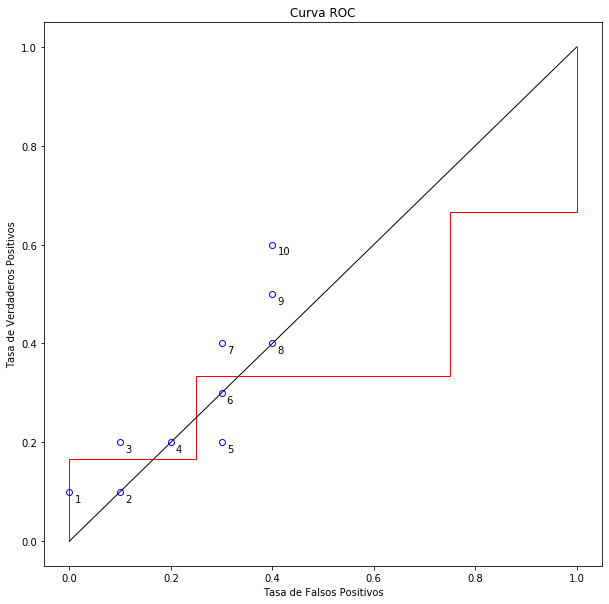

In [35]:
Clase = np.array([1,0,1,0,0,1,1,0,1,1])
Score = np.array([0.8,0.7,0.65,0.6,0.5,0.35,0.3,0.25,0.2,0.1])

fp_r, tp_r, umbral = roc_curve(Clase, Score)
plt.figure(figsize=(10,10))
plt.plot(fp_r, tp_r, lw = 1, color = "red")
plt.plot([0, 1], [0, 1], lw = 1, color = "black")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")

# Aquí se inicializan para que de igual a la corrida a pie
Umbral = min(Score)
Paso = (max(Score) - min(Score)) / 10
N = 10 # ceros
P = 10 # unos
TP = 0 
FP = 0
for i in range(0, 10):    
    if Score[i] > Umbral:
        if Clase[i] == 1:
            TP = TP + 1
        else:
            FP = FP + 1
    else:
        if Clase[i] == 0:
            FP = FP + 1
        else:
            TP = TP + 1
    
    # Graficamos punto
    plt.plot(FP / N, TP / P, "o", mfc = "none", color = "blue")
    plt.annotate(i + 1, (FP / N + 0.01, TP / P - 0.02))    
    Umbral = Umbral + Paso